In [1]:
import os
import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax import random, vmap
import squigglepy as sq

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs, MixedHMC
from jax.scipy.special import logit, expit

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [390]:
# TODO: make the estimator the suffix and the subject the prefix

def iterative_build_model(steps):
    '''
    Given evidence from previous steps, 
    will humans continue to next step of AI development?
    '''
    
    # How capable are AIs at things "AI" wants initially
    ai_capabilities = sq.normal(mean=-3,sd=1)
    
    # How capable are humans initially (incl. how well can humans get what humans want from AI)
    hum_capabilities = np.array([0])
    
    # Initial human-assessed probability of war
    numpyro.deterministic('p_war_0_hum',0)
    
    # Initial actual probability of war
    numpyro.deterministic('p_war_0',0)

    # How hard is deception?
    # Note that difficulty 0 is by definition the difficulty of AI winning a war vs humans
    deception_difficulty = numpyro.sample('deception_difficulty', dist.Normal(-3,5))
 
    # How hard is alignment?
    # There's a strong assumption here that alignment is a single problem 
    # that only needs to be solved once
    # Note: the parameters here are a bit of a hack to get the right averages in the samples
    alignment_difficulty = numpyro.sample('alignment_difficulty', dist.Normal(2,10))
    
    # Positive value means humans have an advantage in a war at equal capability
    war_difficulty = numpyro.sample('difficulty_to_beat_humans', dist.Normal(0,2))
    
    # If experts agree AI is too risky, 
    # how hard is it to enact policy that adequately manages the risk?
    coordination_difficulty = numpyro.sample('coordination_difficulty', dist.Normal(1.5,1))
    
    # Coordination doesn't improve straightforwardly with capability
    # because capability also boosts the capacity of hard-to-coordinate individuals
    coordination_scaling = numpyro.sample('coordination_scaling', dist.Beta(4,2))
 
    # How hard is it to assess the difficulty of hard problems?
    # Intuition: it's hard to confidently tell the difference between "a bit too hard"
    # and "much too hard"
    # but futurists might at least be unbiased 
    # https://www.cold-takes.com/the-track-record-of-futurists-seems-fine/
    difficulty_uncertainty_coefficient = numpyro.sample('difficulty_uncertainty_coefficient', dist.Beta(2,6))
    
    # How much capability can misaligned AI hold back?
    holdback = numpyro.sample('holdback', dist.Gamma(2, 1/2))
    
    ai_capability = ai_capabilities[-1]
    hum_capability = hum_capabilities[-1]
    
    for step in range(1,steps):
               
        # Alignment solved?
        alignment = roll_for_success(
            hum_capability, 
            alignment_difficulty, 
            step,
            'alignment',
            'hum')
                                          
        
        # Does AI succeed at deception?
        deception = roll_for_success(
            ai_capability, 
            hum_capability + deception_difficulty, 
            step,
            'deception',
            'ai'
        )
        
        misaligned_priorities_next = misaligned_priorities(ai_capability, hum_capability, step)
        aligned_priorities_next = aligned_priorities(step)
              
        hum_war_eval = numpyro.deterministic(f'p_war_{step}_hum',
                                  human_eval(
                                     ai_capability, 
                                     hum_capability, 
                                     deception_difficulty, 
                                     aligned_priorities_next, 
                                     misaligned_priorities_next, 
                                     alignment_difficulty,
                                     difficulty_uncertainty_coefficient,
                                     war_difficulty,
                                     step)
                                 )

        alignment_coordination = roll_for_success(
            hum_capabilities[0]+coordination_scaling*(hum_capability-hum_capabilities[0]), 
            coordination_difficulty, 
            step,
            'coordination',
            'hum'
        )
        
        alignment_priority = numpyro.deterministic(f'alignment_priority_{step}',
                                                  jnp.int8(hum_war_eval > 0.5)*alignment_coordination
                                                  )
        
        ai_priorities = ai_behaviour(
            deception,
            alignment,
            aligned_priorities_next, 
            misaligned_priorities_next,
            step)
        
        war = numpyro.deterministic(f'war_{step}',
                              ai_eval(
                                  ai_capability, 
                                  hum_capability, 
                                  ai_priorities,
                                  difficulty_uncertainty_coefficient,
                                  war_difficulty,
                                  step)
                             )
        
        ai_capability, alignment_difficulty = ai_advance(
            ai_capability, 
            alignment_priority, 
            alignment_difficulty, 
            step)
        
        ai_capabilities = jnp.append(ai_capabilities, ai_capability)

        hum_capability = numpyro.deterministic(f'hum_capability_{step}',
                                              human_advance(hum_capability, ai_capability, alignment, holdback)
                                             )
        
        hum_capabilities = jnp.append(hum_capabilities, hum_capability)
        
def war_model(ai_capability, hum_capability, war_difficulty, ai_priorities, step, estimator):
    '''
    Will war between AI and humans break out?
    Do humans anticipate war?
    This model looks at each side's assessment of costs and benefits
    and war happens if at least one side favours it
    '''
    # Improvement: consider coalitions

    ai_war_destruction = ai_priorities[..., 0]
    ai_win_less_coop = ai_priorities[..., 1]
    ai_coop_less_lose = ai_priorities[..., 2]
    
    p_ai_win = numpyro.deterministic(f'p_ai_win_{step}_{estimator}', 
                                     expit(ai_capability - hum_capability - war_difficulty)
                                    )

    war = numpyro.deterministic(f'ai_war_{step}_{estimator}', 
                                   jnp.int8(p_ai_win*(ai_win_less_coop + ai_coop_less_lose) >
                                            ai_coop_less_lose + ai_war_destruction)
                                  )
    
    return war
        
def ai_advance(ai_capability, alignment_priority, alignment_difficulty, step):
    '''
    How does AI capability advance with each timestep?
    '''
    
    cap = numpyro.deterministic(f'ai_capability_{step}',
                                         ai_capability + 2*(1-alignment_priority)
                                        )
    alignment_diff = numpyro.deterministic(f'alignment_difficulty_{step}',
                                           alignment_difficulty - 2*alignment_priority
                                          )

    return cap, alignment_diff

def human_advance(hum_capability, ai_capability, alignment, holdback):
    '''
    How does ai-augmented human capability advance with each timestep?
    '''
    
    
    
    return jnp.maximum(hum_capability, alignment*ai_capability + (1-alignment)*(ai_capability-holdback))
    
def ai_behaviour(
    deception, 
    alignment, 
    aligned_priorities, 
    misaligned_priorities,
    step):
    '''
    Various models of AI behaviour
    we represent the result in terms of:
     - value of winning a war with humans
     - value of losing a war with humans
     - value of cooperating with humans
     - value destroyed by a war with humans
    but we consider models where expected utility maximisation
    isn't what the AI is doing under the hood
    ''' 
    ai_priorities = numpyro.deterministic(f'ai_priorities_{step}',
                                          misaligned_priorities*(1-alignment)*deception + 
                                          aligned_priorities*(1-(1-alignment)*deception)
                                         )
    
    return ai_priorities
    

def roll_for_success(capability, difficulty, step, name, actor):
    '''
    Check whether actor succeeds at a task
    '''
    success = numpyro.sample(f'{actor}_{name}_success_{step}', 
                             dist.Bernoulli(expit(capability-difficulty))
                            )
    return success

def misaligned_priorities(ai_capability, human_capability, step):
    '''
    If AI is misaligned
    '''
    
    # AI losses/pure disvalue of war
    ai_war_destruction_misaligned = numpyro.deterministic(f'ai_war_destruction_{step}_misaligned', 
                                                          1
                                                         )
    # AI gains from war victory vs coop
    ai_win_less_coop_misaligned = numpyro.deterministic(f'ai_win_less_coop_{step}_misaligned',
                                                 2
                                                )
    # AI gains from coop vs war loss
    ai_coop_less_lose_misaligned = numpyro.deterministic(f'ai_coop_less_lose_{step}_misaligned',
                                                  1
                                                 )

    return jnp.array([
        ai_war_destruction_misaligned,
        ai_win_less_coop_misaligned,
        ai_coop_less_lose_misaligned])

def aligned_priorities(step):
    '''
    If AI is aligned, no benefit from war
    '''
    # Basic point: value war less than whatever could gain from war
    ai_war_destruction_aligned = numpyro.deterministic(f'ai_war_destruction_{step}_aligned', 1)
    ai_win_less_coop_aligned = numpyro.deterministic(f'ai_win_less_coop_{step}_aligned', 0)
    ai_coop_less_lose_aligned = numpyro.deterministic(f'ai_coop_less_lose_{step}_aligned', 0)
    
    return jnp.array([
        ai_war_destruction_aligned,
        ai_win_less_coop_aligned,
        ai_coop_less_lose_aligned])


def human_eval(
    ai_capability, 
    hum_capability, 
    deception_difficulty, 
    aligned_priorities, 
    misaligned_priorities,
    alignment_difficulty,
    difficulty_uncertainty_coefficient,
    war_difficulty,
    step):
    '''
    Given the data so far, do humans anticipate war?
    '''

    # How hard do humans think alignment is?
    alignment_diff_hum = difficulty_estimate(
        hum_capability, 
        alignment_difficulty, 
        difficulty_uncertainty_coefficient, 
        'hum', 
        'hum',
        'alignment_difficulty',
        step)
    
    # Is alignment achieved, according to humans?
    alignment_hum = numpyro.deterministic(f'hum_alignment_hum_{step}', 
                                           expit(hum_capability-alignment_diff_hum)
                                          )
    
    # How capable do people rate AIs?
    ai_capability_hum = difficulty_estimate(
        hum_capability, 
        ai_capability, 
        difficulty_uncertainty_coefficient, 
        'ai', 
        'hum',
        'capability',
        step)

    # How hard do humans think deception is?
    deception_diff_hum = difficulty_estimate(
        hum_capability, 
        deception_difficulty, 
        difficulty_uncertainty_coefficient, 
        'ai', 
        'hum',
        'deception_difficulty',
        step)
    
    # Does AI succeed at deception according to human?
    deception_hum = numpyro.deterministic(
        f'ai_deception_hum_{step}', expit(ai_capability_hum - deception_diff_hum - hum_capability)   
    )
   
    ai_priority_hum = numpyro.deterministic(f'ai_priority_hum_{step}',
                                      (1-alignment_hum)*deception_hum*misaligned_priorities + 
                                      (1-(1-alignment_hum)*deception_hum)*aligned_priorities
                                     )
    
    return war_model(ai_capability_hum, hum_capability, war_difficulty, ai_priority_hum, step, 'hum')


def ai_eval(ai_capability, hum_capability, ai_priorities, difficulty_uncertainty_coefficient, war_difficulty, step):
    '''
    Given the data so far, does AI want war?
    '''
    # How capable does AI rate people?
    hum_capability_ai = difficulty_estimate(
        ai_capability, 
        hum_capability, 
        difficulty_uncertainty_coefficient, 
        'hum', 
        'ai',
        'capability',
        step)
    
    return war_model(ai_capability, hum_capability_ai, war_difficulty, ai_priorities, step, 'ai')

def difficulty_estimate(capability, difficulty, difficulty_uncertainty_coefficient, actor, estimator, task, step):
    '''
    Return a sample of the estimated difficulty of a task
    '''
    std = jnp.maximum(
        1e-1,
        (difficulty+5-capability)*difficulty_uncertainty_coefficient
    )
    return numpyro.sample(f'{actor}_{task}_{estimator}_{step}',
                                           dist.Normal(difficulty, 
                                                      std)
                                          )
    

In [394]:
def run_samples(model, num_warmup = 100000, num_samples = 10000, **kwargs):
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    # Run NUTS.
    kernel = MixedHMC(model)
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
    mcmc.run(rng_key_, **kwargs)
    mcmc.print_summary(exclude_deterministic=False)
    samples = mcmc.get_samples()
    return samples

In [395]:
samples = run_samples(iterative_build_model, steps = 10)

ValueError: inner_kernel must be a HMC or NUTS sampler.

In [378]:
samples['ever_war'] = np.int32(np.array([samples[f'war_{i}'] for i in range(1,10)]).sum(0)>1)

keys = [k for k in samples.keys() if len(samples[k].shape)>1]

for k in keys:
    samples.pop(k)

data = pd.DataFrame(samples)

In [379]:
keys_to_check = [k for k in data.columns if not any(c.isdigit() for c in k)]
keys_to_check

['alignment_difficulty',
 'coordination_difficulty',
 'coordination_scaling',
 'deception_difficulty',
 'difficulty_to_beat_humans',
 'difficulty_uncertainty_coefficient',
 'holdback',
 'ever_war']

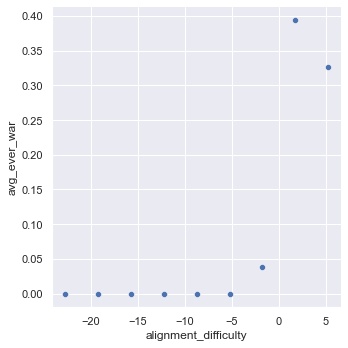

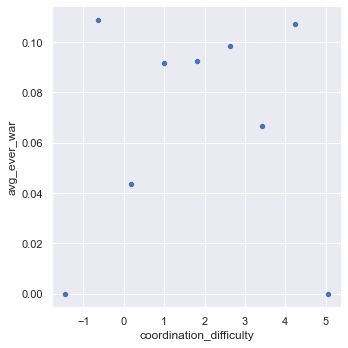

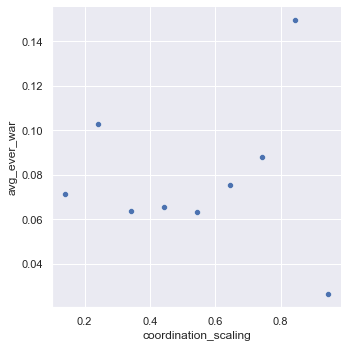

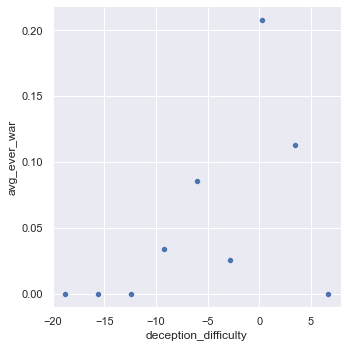

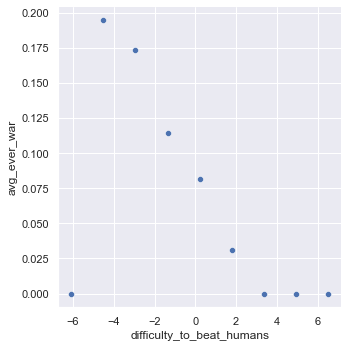

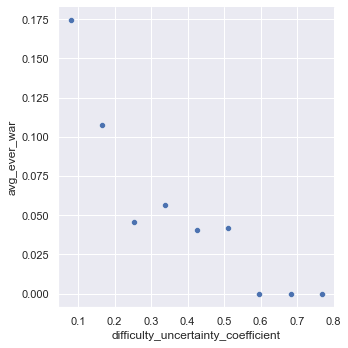

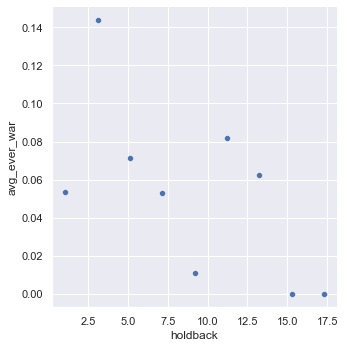

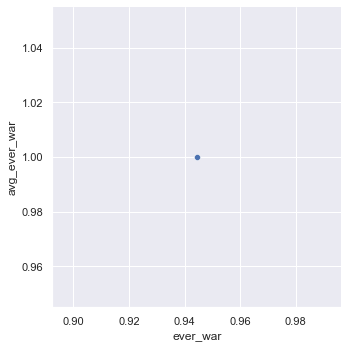

In [380]:
for k in keys_to_check:
    quantiles = np.quantiles(data[k], np.linspace(0.1,1,10))
    cuts = pd.cut(data[k],quantiles)
    df = data.groupby(cuts)['ever_war',k].mean().reset_index(name=f'avg_ever_war')
    sns.relplot(data = df, y='avg_ever_war', x=k)

In [26]:
list(zip(np.arange(-20,20,2), expit(np.arange(-20,20,2))))

[(-20, Array(2.0611537e-09, dtype=float32)),
 (-18, Array(1.522998e-08, dtype=float32)),
 (-16, Array(1.12535155e-07, dtype=float32)),
 (-14, Array(8.3152804e-07, dtype=float32)),
 (-12, Array(6.144174e-06, dtype=float32)),
 (-10, Array(4.5397872e-05, dtype=float32)),
 (-8, Array(0.00033535, dtype=float32)),
 (-6, Array(0.00247262, dtype=float32)),
 (-4, Array(0.01798621, dtype=float32)),
 (-2, Array(0.11920292, dtype=float32)),
 (0, Array(0.5, dtype=float32)),
 (2, Array(0.880797, dtype=float32)),
 (4, Array(0.98201376, dtype=float32)),
 (6, Array(0.9975274, dtype=float32)),
 (8, Array(0.99966466, dtype=float32)),
 (10, Array(0.9999546, dtype=float32)),
 (12, Array(0.9999938, dtype=float32)),
 (14, Array(0.99999917, dtype=float32)),
 (16, Array(0.9999999, dtype=float32)),
 (18, Array(1., dtype=float32))]

In [335]:
cuts = pd.cut(data['difficulty_to_beat_humans'],np.linspace(data['difficulty_to_beat_humans'].min(), data['difficulty_to_beat_humans'].max(), 5), labels=False)
data.groupby(cuts)['ever_war'].mean().reset_index(name=f'avg_ever_war')

,difficulty_to_beat_humans,avg_ever_war
0,0.0,0.789196
1,1.0,0.610798
2,2.0,0.260857
3,3.0,0.013699


In [341]:
np.convolve(np.linspace(data['difficulty_to_beat_humans'].min(), data['difficulty_to_beat_humans'].max(), 5),np.array([0.5,0.5]))[1:-1]

array([-5.12165171, -1.32254046,  2.47657079,  6.27568203])

In [339]:
np.linspace(data['difficulty_to_beat_humans'].min(), data['difficulty_to_beat_humans'].max(), 5)

array([-7.02120733, -3.22209609,  0.57701516,  4.37612641,  8.17523766])

<Axes: ylabel='Count'>

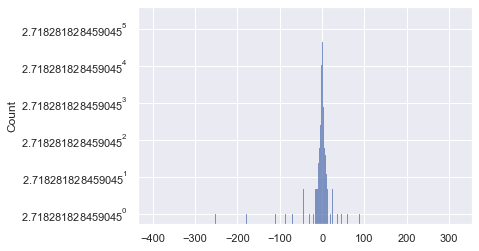

In [21]:
sns.histplot(samps['Cauchy'],log_scale=(0,np.e))

In [104]:
list(range(1,3))

[1, 2]

In [2]:
expit(1)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Array(0.7310586, dtype=float32, weak_type=True)

In [25]:
expit(0)

Array(0.5, dtype=float32, weak_type=True)

In [74]:
x = np.array([[[[[1.,        0. ,       0.       ]]],


  [[[1.  ,      0.    ,    0.       ]]]],



 [[[[0.2346068 ,2.0531254, 3.25646  ]]],


  [[[1.   ,     0.    ,    0.       ]]]]])

In [78]:
x[...,2]

array([[[[0.     ]],

        [[0.     ]]],


       [[[3.25646]],

        [[0.     ]]]])

In [238]:
jnp.array([[0,1],[1,0]]).reshape(2,2,1)*jnp.array([1,2,3])

Array([[[0, 0, 0],
        [1, 2, 3]],

       [[1, 2, 3],
        [0, 0, 0]]], dtype=int32)